In [14]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

## Eliciting expert prior

Specifying a subjective prior is how practitioners incorporate domain knowledge about the problem into our mathematical framework. Allowing domain knowledge is useful for many reasons:

- Aids speeds of MCMC convergence. For example, if we know the unknown parameter is strictly positive, then we can restrict our attention there, hence saving time that would otherwise be spent exploring negative values.
- More accurate inference. By weighing prior values near the true unknown value higher, we are narrowing our eventual inference (by making the posterior tighter around the unknown) 
- Express our uncertainty better. See the *Price is Right* problem in Chapter 5.

plus many other reasons. Of course, practitioners of Bayesian methods are not experts in every field, so we must turn to domain experts to craft our priors. We must be careful with how we elicit these priors though. Some things to consider:

1. From experience, I would avoid introducing Betas, Gammas, etc. to non-Bayesian practitioners. Furthermore, non-statisticians can get tripped up by how a continuous probability function can have a value exceeding one.

2. Individuals often neglect the rare *tail-events* and put too much weight around the mean of distribution. 

3. Related to above is that almost always individuals will under-emphasize the uncertainty in their guesses.

Eliciting priors from non-technical experts is especially difficult. Rather than introduce the notion of probability distributions, priors, etc. that may scare an expert, there is a much simpler solution. 

### Trial roulette method 


The *trial roulette method* [8] focuses on building a prior distribution by placing counters (think casino chips) on what the expert thinks are possible outcomes. The expert is given $N$ counters (say $N=20$) and is asked to place them on a pre-printed grid, with bins representing intervals.  Each column would represent their belief of the probability of getting the corresponding bin result. Each chip would represent an $\frac{1}{N} = 0.05$ increase in the probability of the outcome being in that interval. For example [9]:

> A student is asked to predict the mark in a future exam. The figure below shows a completed grid for the elicitation of a subjective probability distribution. The horizontal axis of the grid shows the possible bins (or mark intervals) that the student was asked to consider. The numbers in top row record the number of chips per bin. The completed grid (using a total of 20 chips) shows that the student believes there is a 30% chance that the mark will be between 60 and 64.9.


<img style="margin: auto" src="http://img641.imageshack.us/img641/4716/chipsbinscrisp.png" />

From this, we can fit a distribution that captures the expert's choice. Some reasons in favor of using this technique are:

1. Many questions about the shape of the expert's subjective probability distribution can be answered without the need to pose a long series of questions to the expert - the statistician can simply read off density above or below any given point, or that between any two points.

2. During the elicitation process, the experts can move around the chips if unsatisfied with the way they placed them initially - thus they can be sure of the final result to be submitted.

3. It forces the expert to be coherent in the set of probabilities that are provided. If all the chips are used, the probabilities must sum to one.

4. Graphical methods seem to provide more accurate results, especially for participants with modest levels of statistical sophistication.

##### Example: Stock Returns


Take note stock brokers: you're doing it wrong. When choosing which stocks to pick, an analyst will often look at the *daily return* of the stock. Suppose $S_t$ is the price of the stock on day $t$, then the daily return on day $t$ is :

$$r_t = \frac{ S_t - S_{t-1} }{ S_{t-1} } $$

The *expected daily return* of a stock is denoted $\mu = E[ r_t ]$. Obviously, stocks with high expected returns are desirable. Unfortunately, stock returns are so filled with noise that it is very hard to estimate this parameter. Furthermore, the parameter might change over time (consider the rises and falls of AAPL stock), hence it is unwise to use a large historical dataset. 

Historically, the expected return has been estimated by using the sample mean. This is a bad idea. As mentioned, the sample mean of a small sized dataset has enormous potential to be very wrong (again, see Chapter 4 for full details). Thus Bayesian inference is the correct procedure here, since we are able to see our uncertainty along with probable values.

For this exercise, we will be examining the daily returns of the AAPL, GOOG, MSFT and AMZN. Before we pull in the data, suppose we ask our a stock fund manager (an expert in finance, but see [10] ), 

> What do you think the return profile looks like for each of these companies?

Our stock broker, without needing to know the language of Normal distributions, or priors, or variances, etc. creates four distributions using the trial roulette method above. Suppose they look enough like Normals, so we fit Normals to them. They may look like: 

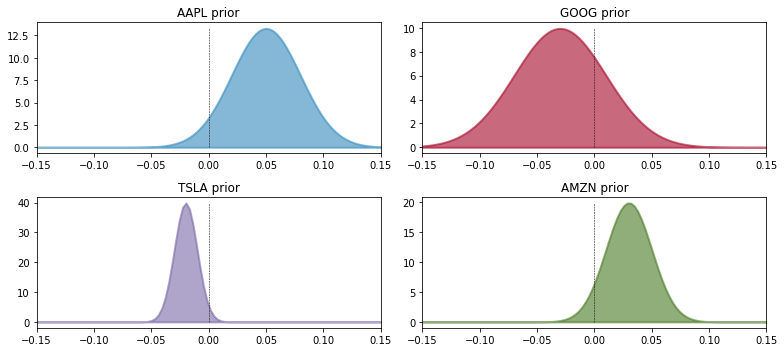

In [15]:
figsize(11., 5)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

normal = stats.norm
x = np.linspace(-0.15, 0.15, 100)

expert_prior_params = {"AAPL":(0.05, 0.03),
                 "GOOG":(-0.03, 0.04), 
                 "TSLA": (-0.02, 0.01), 
                 "AMZN": (0.03, 0.02), 
                 }

for i, (name, params) in enumerate(expert_prior_params.items()):
    plt.subplot(2, 2, i+1)
    y = normal.pdf(x, params[0], scale = params[1])
    #plt.plot( x, y, c = colors[i] )
    plt.fill_between(x, 0, y, color = colors[i], linewidth=2,
                     edgecolor = colors[i], alpha = 0.6)
    plt.title(name + " prior")
    plt.vlines(0, 0, y.max(), "k","--", linewidth = 0.5)
    plt.xlim(-0.15, 0.15)
plt.tight_layout()

Note that these are subjective priors: the expert has a personal opinion on the stock returns of each of these companies, and is expressing them in a distribution. He's not wishful thinking -- he's introducing domain knowledge.

In order to better model these returns, we should investigate the *covariance matrix* of the returns. For example, it would be unwise to invest in two stocks that are highly correlated, since they are likely to tank together (hence why fund managers suggest a diversification strategy). We will use the *Wishart distribution* for this, introduced earlier.

Let's get some historical data for these stocks. We will use the covariance of the returns as a starting point for our Wishart random variable. This is not empirical bayes (as we will go over later) because we are only deciding the starting point, not influencing the parameters.

In [16]:
# I wish I could have used Pandas as a prereq for this book, but oh well.
import datetime
import collections
import ystockquote as ysq
import pandas as pd

n_observations = 100 # we will truncate the the most recent 100 days.

stocks = ["AAPL", "GOOG", "TSLA", "AMZN"]

enddate = "2015-04-27"
startdate = "2012-09-01"

CLOSE = 6

stock_closes = pd.DataFrame()

for stock in stocks:
    x = np.array(ysq.get_historical_prices(stock, startdate, enddate))
    stock_series = pd.Series(x[1:,CLOSE].astype(float), name=stock)
    stock_closes[stock] = stock_series

stock_closes = stock_closes[::-1]
stock_returns = stock_closes.pct_change()[1:][-n_observations:]
    
dates = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), x[1:n_observations+1,0]))

FileNotFoundError: [Errno 2] No such file or directory: 'AAPL.csv'

And here let's form our basic model:

In [17]:
import pymc as pm
import theano.tensor as tt
from theano.tensor.nlinalg import matrix_inverse, diag, matrix_dot

prior_mu = np.array([x[0] for x in expert_prior_params.values()])
prior_std = np.array([x[1] for x in expert_prior_params.values()])

init = stock_returns.cov()

with pm.Model() as model:
    cov_matrix = pm.WishartBartlett("covariance", np.diag(prior_std**2), 10, testval = init)

    mu = pm.Normal("returns", mu=prior_mu, sd=1, shape=4)

In file included from /Users/TO/.theano/compiledir_Darwin-17.3.0-x86_64-i386-64bit-i386-3.6.3-64/lazylinker_ext/mod.cpp:1:
In file included from /anaconda3/include/python3.6m/Python.h:25:
/anaconda3/bin/../include/c++/v1/stdio.h:108:15: fatal error: 'stdio.h' file not found
#include_next <stdio.h>
              ^~~~~~~~~
1 error generated.



00001	#include <Python.h>
00002	#include "theano_mod_helper.h"
00003	#include "structmember.h"
00004	#include <sys/time.h>
00005	
00006	#if PY_VERSION_HEX >= 0x03000000
00007	#include "numpy/npy_3kcompat.h"
00008	#define PyCObject_AsVoidPtr  NpyCapsule_AsVoidPtr
00009	#define PyCObject_GetDesc  NpyCapsule_GetDesc
00010	#define PyCObject_Check NpyCapsule_Check
00011	#endif
00012	
00013	#ifndef Py_TYPE
00014	#define Py_TYPE(obj) obj->ob_type
00015	#endif
00016	
00017	/**
00018	
00019	TODO: 
00020	- Check max supported depth of recursion
00021	- CLazyLinker should add context information to errors caught during evaluation. Say what node we were on, add the traceback attached to the node.
00022	- Clear containers of fully-useed intermediate results if allow_gc is 1
00023	- Add timers for profiling
00024	- Add support for profiling space used.
00025	
00026	
00027	  */
00028	static double pytime(const struct timeval * tv)
00029	{
00030	  struct timeval t;
00031	  if (!tv)
00032	    {
00033	 

Exception: Compilation failed (return status=1): In file included from /Users/TO/.theano/compiledir_Darwin-17.3.0-x86_64-i386-64bit-i386-3.6.3-64/lazylinker_ext/mod.cpp:1:. In file included from /anaconda3/include/python3.6m/Python.h:25:. /anaconda3/bin/../include/c++/v1/stdio.h:108:15: fatal error: 'stdio.h' file not found. #include_next <stdio.h>.               ^~~~~~~~~. 1 error generated.. 

Here are the returns for our chosen stocks:

In [ ]:
figsize(12.5, 4)

cum_returns = np.cumprod(1 + stock_returns) - 1
cum_returns.index = dates[::-1]
cum_returns.plot()

plt.legend(loc = "upper left")
plt.title("Return space")
plt.ylabel("Return of $1 on first date, x100%");

In [ ]:
figsize(11., 5 )

for i, _stock in enumerate(stocks):
    plt.subplot(2,2,i+1)
    plt.hist(stock_returns[_stock], bins=20,
             normed = True, histtype="stepfilled",
             color=colors[i], alpha=0.7)
    plt.title(_stock + " returns")
    plt.xlim(-0.15, 0.15)

plt.tight_layout()
plt.suptitle("Histogram of daily returns", size =14);

Below we perform the inference on the posterior mean return and posterior covariance matrix. 

In [18]:
with model:
    obs = pm.MvNormal("observed returns", mu=mu, cov=cov_matrix, observed=stock_returns)
    step = pm.NUTS()
    trace = pm.sample(5000, step=step)

NameError: name 'model' is not defined

In [19]:
figsize(12.5,4)

#examine the mean return first.
mu_samples = trace["returns"]

for i in range(4):
    plt.hist(mu_samples[:,i], alpha = 0.8 - 0.05*i, bins = 30,
             histtype="stepfilled", normed=True, 
             label = "%s" % stock_returns.columns[i])

plt.vlines(mu_samples.mean(axis=0), 0, 500, linestyle="--", linewidth = .5)

plt.title("Posterior distribution of $\mu$, daily stock returns")
plt.legend();

NameError: name 'trace' is not defined

(Plots like these are what inspired the book's cover.)

What can we say about the results above? Clearly TSLA has been a strong performer, and our analysis suggests that it has an almost 1% daily return! Similarly, most of the distribution of AAPL is negative, suggesting that its *true daily return* is negative.


You may not have immediately noticed, but these variables are a whole order of magnitude *less* than our priors on them. For example, to put these one the same scale as the above prior distributions:

NameError: name 'mu_samples' is not defined

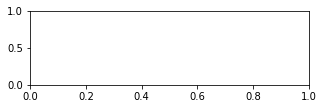

In [20]:
figsize(11.0,3)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist(mu_samples[:,i], alpha = 0.8 - 0.05*i, bins = 30,
             histtype="stepfilled", normed=True, color = colors[i],
             label = "%s" % stock_returns.columns[i])
    plt.title("%s" % stock_returns.columns[i])
    plt.xlim(-0.15, 0.15)
    
plt.suptitle("Posterior distribution of daily stock returns")
plt.tight_layout()

Why did this occur? Recall how I mentioned that finance has a very very low signal to noise ratio. This implies an environment where inference is much more difficult. One should be careful about over-interpreting these results: notice (in the first figure) that each distribution is positive at 0, implying that the stock may return nothing. Furthermore, the subjective priors influenced the results. From the fund managers point of view, this is good as it reflects his updated beliefs about the stocks, whereas from a neutral viewpoint this can be too subjective of a result.  

Below we show the posterior correlation matrix, and posterior standard deviations. An important caveat to know is that the Wishart distribution models the *inverse covariance matrix*, so we must invert it to get the covariance matrix. We also normalize the matrix to acquire the *correlation matrix*. Since we cannot plot hundreds of matrices effectively, we settle by summarizing the posterior distribution of correlation matrices by showing the *mean posterior correlation matrix* (defined on line 2).

In [21]:
cov_samples = trace["covariance"]
mean_covariance_matrix = cov_samples.mean(axis=0)

def cov2corr(A):
    """
    covariance matrix to correlation matrix.
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    #A[ np.diag_indices(A.shape[0]) ] = np.ones( A.shape[0] )
    return A


plt.subplot(1,2,1)
plt.imshow(cov2corr(mean_covariance_matrix) , interpolation="none", 
                cmap = "hot") 
plt.xticks(np.arange(4), stock_returns.columns)
plt.yticks(np.arange(4), stock_returns.columns)
plt.colorbar(orientation="vertical")
plt.title("(mean posterior) Correlation Matrix")

plt.subplot(1,2,2)
plt.bar(np.arange(4), np.sqrt(np.diag(mean_covariance_matrix)),
        color = "#348ABD", alpha = 0.7)
plt.xticks(np.arange(4) + 0.5, stock_returns.columns);
plt.title("(mean posterior) standard deviations of daily stock returns")

plt.tight_layout();


NameError: name 'trace' is not defined

Looking at the above figures, we can say that likely TSLA has an above-average volatility (looking at the return graph this is quite clear). The correlation matrix shows that there are not strong correlations present, but perhaps GOOG and AMZN express a higher correlation (about 0.30).  

With this Bayesian analysis of the stock market, we can throw it into a Mean-Variance optimizer (which I cannot stress enough, do not use with frequentist point estimates) and find the minimum. This optimizer balances the tradeoff between a high return and high variance.

$$ w_{opt} = \max_{w} \frac{1}{N}\left( \sum_{i=0}^N \mu_i^T w - \frac{\lambda}{2}w^T\Sigma_i w \right)$$

where $\mu_i$ and $\Sigma_i$ are the $i$th posterior estimate of the mean returns and the covariance matrix. This is another example of loss function optimization.

### Protips for the Wishart distribution

If you plan to be using the Wishart distribution, read on. Else, feel free to skip this. 

In the problem above, the Wishart distribution behaves pretty nicely. Unfortunately, this is rarely the case. The problem is that estimating an $NxN$ covariance matrix involves estimating $\frac{1}{2}N(N-1)$ unknowns. This is a large number even for modest $N$. Personally, I've tried performing a similar simulation as above with $N = 23$ stocks, and ended up giving considering that I was requesting my MCMC simulation to estimate at least $\frac{1}{2}23*22 = 253$ additional unknowns (plus the other interesting unknowns in the problem). This is not easy for MCMC. Essentially, you are asking you MCMC to traverse 250+ dimensional space. And the problem seemed so innocent initially! Below are some tips, in order of supremacy:

1. Use conjugancy if it applies. See section below.

2. Use a good starting value. What might be a good starting value? Why, the data's sample covariance matrix is! Note that this is not empirical Bayes: we are not touching the prior's parameters, we are modifying the starting value of the MCMC. Due to numerical instability, it is best to truncate the floats in the sample covariance matrix down a few degrees of precision (e.g. instability can cause unsymmetrical matrices, which can cause PyMC3 to cry.). 

3. Provide as much domain knowledge in the form of priors, if possible. I stress *if possible*. It is likely impossible to have an estimate about each $\frac{1}{2}N(N-1)$ unknown. In this case, see number 4.

4. Use empirical Bayes, i.e. use the sample covariance matrix as the prior's parameter.

5. For problems where $N$ is very large, nothing is going to help. Instead, ask, do I really care about *every* correlation? Probably not. Further ask yourself, do I really really care about correlations? Possibly not. In finance, we can set an informal hierarchy of what we might be interested in the most: first a good estimate of $\mu$, the variances along the diagonal of the covariance matrix are secondly important, and finally the correlations are least important. So, it might be better to ignore the $\frac{1}{2}(N-1)(N-2)$ correlations and instead focus on the more important unknowns.

**Another thing** to note is that the implementation of the Wishart distribution has changed in from PyMC to PyMC3. Wishart distribution matrices are required to have certain mathematical characteristics that are very restrictive. This makes it so that it is impossible for MCMC methods to propose matrices that will be accepted in our sampling procedure. With our model here we sample the Bartlett decomposition of a Wishart distribution matrix and use that to calculate our samples for the covariance matrix (http://en.wikipedia.org/wiki/Wishart_distribution#Bartlett_decomposition).

## Conjugate Priors

Recall that a $\text{Beta}$ prior with $\text{Binomial}$ data implies a $\text{Beta}$ posterior. Graphically:

$$ \underbrace{\text{Beta}}_{\text{prior}} \cdot \overbrace{\text{Binomial}}^{\text{data}} = \overbrace{\text{Beta}}^{\text{posterior} } $$ 

Notice the $\text{Beta}$ on both sides of this equation (no, you cannot cancel them, this is not a *real* equation). This is a really useful property. It allows us to avoid using MCMC, since the posterior is known in closed form. Hence inference and analytics are easy to derive. This shortcut was the heart of the  Bayesian Bandit algorithm above. Fortunately, there is an entire family of distributions that have similar behaviour.  

Suppose $X$ comes from, or is believed to come from, a well-known distribution, call it $f_{\alpha}$, where $\alpha$ are possibly unknown parameters of $f$. $f$ could be a Normal distribution, or Binomial distribution, etc. For particular distributions $f_{\alpha}$, there may exist a prior distribution $p_{\beta}$, such that:

$$ \overbrace{p_{\beta}}^{\text{prior}} \cdot \overbrace{f_{\alpha}(X)}^{\text{data}} = \overbrace{p_{\beta'}}^{\text{posterior} } $$ 

where $\beta'$ is a different set of parameters *but $p$ is the same distribution as the prior*. A prior $p$ that satisfies this relationship is called a *conjugate prior*. As I mentioned, they are useful computationally, as we can avoided approximate inference using MCMC and go directly to the posterior. This sounds great, right?

Unfortunately, not quite. There are a few issues with conjugate priors.

1. The conjugate prior is not objective. Hence only useful when a subjective prior is required. It is not guaranteed that the conjugate prior can accommodate the practitioner's subjective opinion.

2. There typically exist conjugate priors for simple, one dimensional problems. For larger problems, involving more complicated structures, hope is lost to find a conjugate prior. For smaller models, Wikipedia has a nice [table of conjugate priors](http://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions).

Really, conjugate priors are only useful for their mathematical convenience: it is simple to go from prior to posterior. I personally see conjugate priors as only a neat mathematical trick, and offer little insight into the problem at hand. 

## Jefferys Priors

Earlier, we talked about objective priors rarely being *objective*. Partly what we mean by this is that we want a prior that doesn't bias our posterior estimates. The flat prior seems like a reasonable choice as it assigns equal probability to all values. 

But the flat prior is not transformation invariant. What does this mean? Suppose we have a random variable $\textbf X$ from Bernoulli($\theta$). We define the prior on $p(\theta) = 1$. 

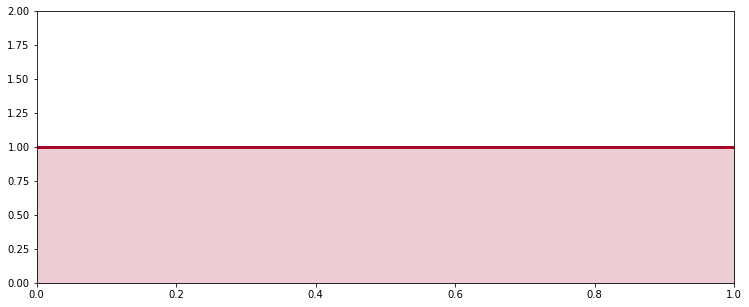

In [22]:
figsize(12.5, 5)

x = np.linspace(0.000 ,1, 150)
y = np.linspace(1.0, 1.0, 150)
lines = plt.plot(x, y, color="#A60628", lw = 3)
plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
plt.autoscale(tight=True)
plt.ylim(0, 2);

Now, let's transform $\theta$ with the function $\psi = log \frac{\theta}{1-\theta}$. This is just a function to stretch $\theta$ across the real line. Now how likely are different values of $\psi$ under our transformation.

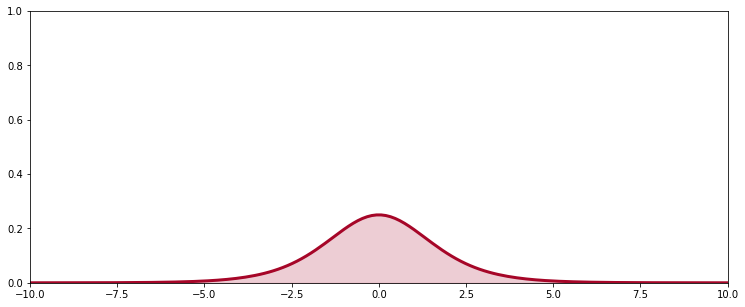

In [23]:
figsize(12.5, 5)

psi = np.linspace(-10 ,10, 150)
y = np.exp(psi) / (1 + np.exp(psi))**2
lines = plt.plot(psi, y, color="#A60628", lw = 3)
plt.fill_between(psi, 0, y, alpha = 0.2, color = lines[0].get_color())
plt.autoscale(tight=True)
plt.ylim(0, 1);

Oh no! Our function is no longer flat. It turns out flat priors do carry information in them after all. The point of Jeffreys Priors is to create priors that don't accidentally become informative when you transform the variables you placed them originally on.

Jeffreys Priors are defined as:

$$p_J(\theta) \propto \mathbf{I}(\theta)^\frac{1}{2}$$
$$\mathbf{I}(\theta) = - \mathbb{E}\bigg[\frac{d^2 \text{ log } p(X|\theta)}{d\theta^2}\bigg]$$

$\mathbf{I}$ being the *Fisher information*

## Effect of the prior as $N$ increases

In the first chapter, I proposed that as the amount of our observations or data increases, the influence of the prior decreases. This is intuitive. After all, our prior is based on previous information, and eventually enough new information will shadow our previous information's value. The smothering of the prior by enough data is also helpful: if our prior is significantly wrong, then the self-correcting nature of the data will present to us a *less wrong*, and eventually *correct*, posterior. 

We can see this mathematically. First, recall Bayes Theorem from Chapter 1 that relates the prior to the posterior. The following is a sample from [What is the relationship between sample size and the influence of prior on posterior?](http://stats.stackexchange.com/questions/30387/what-is-the-relationship-between-sample-size-and-the-influence-of-prior-on-poste)[1] on CrossValidated.

>The posterior distribution for a parameter $\theta$, given a data set ${\textbf X}$ can be written as 

$$p(\theta | {\textbf X}) \propto \underbrace{p({\textbf X} | \theta)}_{{\textrm likelihood}}  \cdot  \overbrace{ p(\theta) }^{ {\textrm prior} }  $$



>or, as is more commonly displayed on the log scale, 

$$ \log( p(\theta | {\textbf X})  ) = c + L(\theta;{\textbf X}) + \log(p(\theta)) $$

>The log-likelihood, $L(\theta;{\textbf X}) = \log \left( p({\textbf X}|\theta) \right)$, **scales with the sample size**, since it is a function of the data, while the prior density does not. Therefore, as the sample size increases, the absolute value of $L(\theta;{\textbf X})$ is getting larger while $\log(p(\theta))$ stays fixed (for a fixed value of $\theta$), thus the sum $L(\theta;{\textbf X}) + \log(p(\theta))$ becomes more heavily influenced by $L(\theta;{\textbf X})$ as the sample size increases. 

There is an interesting consequence not immediately apparent. As the sample size increases, the chosen prior has less influence. Hence inference converges regardless of chosen prior, so long as the areas of non-zero probabilities are the same. 

Below we visualize this. We examine the convergence of two posteriors of a Binomial's parameter $\theta$, one with a flat prior and the other with a biased prior towards 0. As the sample size increases, the posteriors, and hence the inference, converge.

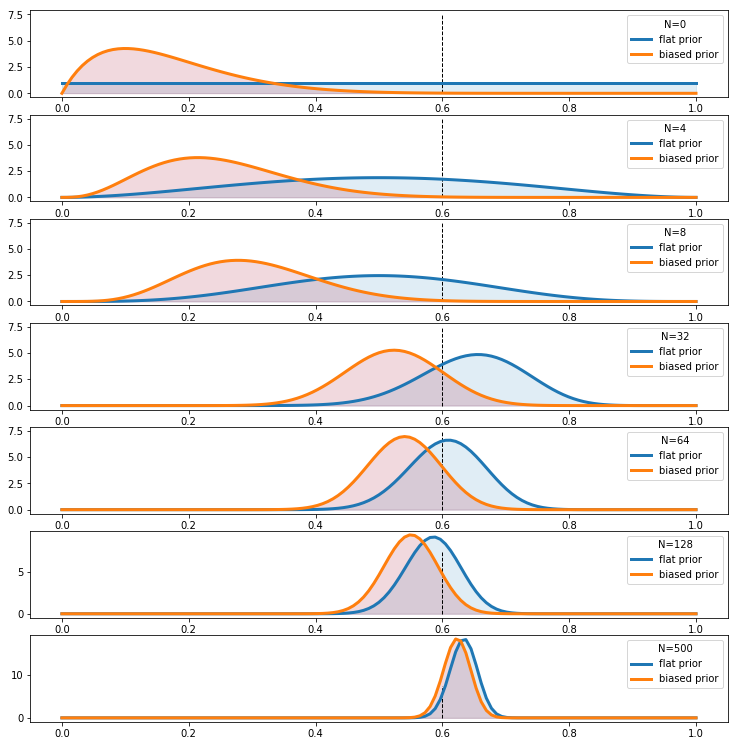

In [24]:
figsize(12.5, 15)

p = 0.6
beta1_params = np.array([1.,1.])
beta2_params = np.array([2,10])
beta = stats.beta

x = np.linspace(0.00, 1, 125)
data = stats.bernoulli.rvs(p, size=500)

plt.figure()
for i,N in enumerate([0,4,8, 32,64, 128, 500]):
    s = data[:N].sum() 
    plt.subplot(8,1,i+1)
    params1 = beta1_params + np.array([s, N-s])
    params2 = beta2_params + np.array([s, N-s])
    y1,y2 = beta.pdf(x, *params1), beta.pdf( x, *params2)
    plt.plot(x,y1, label = r"flat prior", lw =3)
    plt.plot(x, y2, label = "biased prior", lw= 3)
    plt.fill_between(x, 0, y1, color ="#348ABD", alpha = 0.15) 
    plt.fill_between(x, 0, y2, color ="#A60628", alpha = 0.15) 
    plt.legend(title = "N=%d" % N)
    plt.vlines(p, 0.0, 7.5, linestyles = "--", linewidth=1)
    #plt.ylim( 0, 10)#


Keep in mind, not all posteriors will "forget" the prior this quickly. This example was just to show that *eventually* the prior is forgotten. The "forgetfulness" of the prior as we become awash in more and more data is the reason why Bayesian and Frequentist inference eventually converge as well.